In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree

import matplotlib
from matplotlib import pyplot as plt

import fitsio
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity  

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### Contour checks
redshift vs redshift plot, within the contouring check.

In [2]:
knr2 = fits.open("superset_with_zphot_kNR2.fits")

knr2data = knr2[1].data

knr2[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  240 / length of dimension 1                          
NAXIS2  =              1295502 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   39 / number of table fields                         
TTYPE1  = 'source_id'                                                           
TFORM1  = 'K       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'unwise_objid'                                                        
TFORM2  = '16A     '        

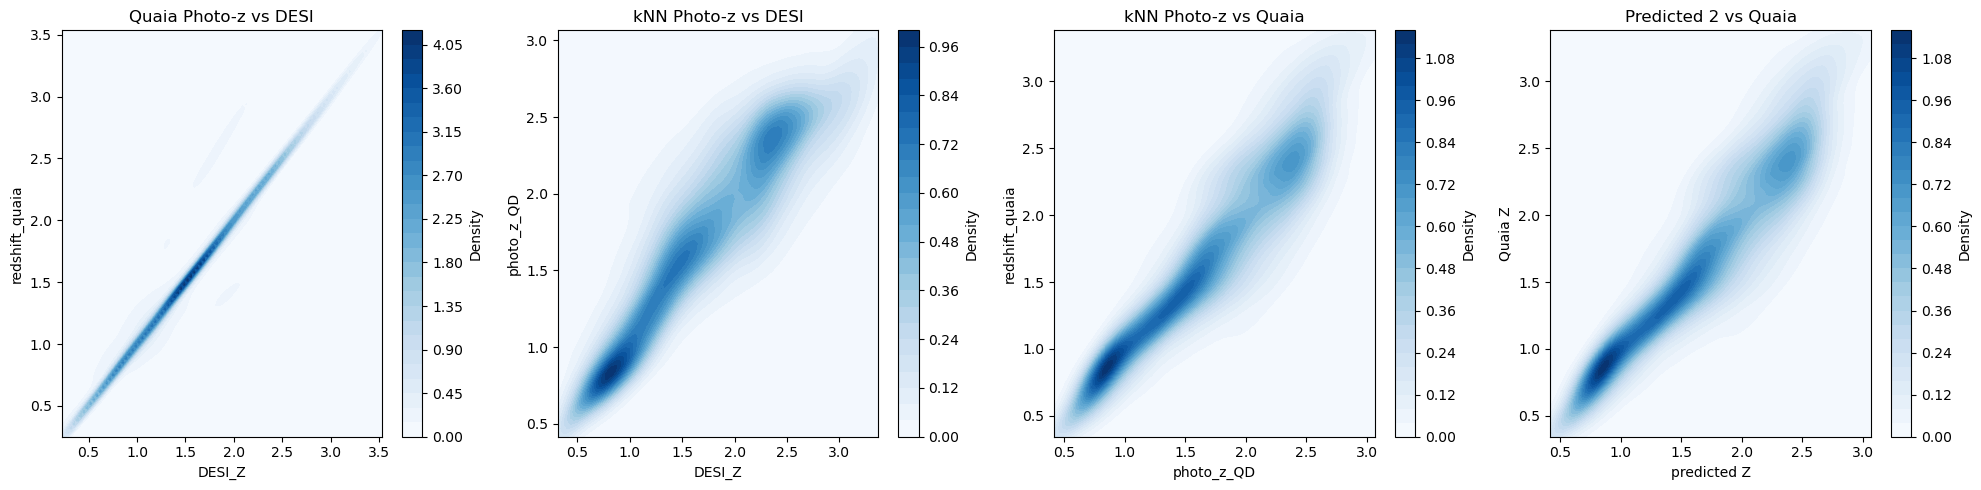

In [3]:
def contour_density_lineplot(x, y, ax, xlabel, ylabel, title, gridsize=100, levels=30, cmap='Blues'):
    # NaN eliminate
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # Grid
    xmin, xmax = np.percentile(x, [0.5, 99.5])
    ymin, ymax = np.percentile(y, [0.5, 99.5])
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, gridsize),
        np.linspace(ymin, ymax, gridsize)
    )
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # contour
    cf = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.colorbar(cf, ax=ax, label='Density')

fig, axs = plt.subplots(1, 4, figsize=(20, 5), facecolor='white')

contour_density_lineplot(knr2data['DESI_Z'], knr2data['redshift_quaia'], axs[0],
                         'DESI_Z', 'redshift_quaia', 'Quaia Photo-z vs DESI')

contour_density_lineplot(knr2data['DESI_Z'], knr2data['Photo_z_QD'], axs[1],
                         'DESI_Z', 'photo_z_QD', 'kNN Photo-z vs DESI')

contour_density_lineplot(knr2data['Photo_z_QD'], knr2data['redshift_quaia'], axs[2],
                         'photo_z_QD', 'redshift_quaia', 'kNN Photo-z vs Quaia')

contour_density_lineplot(knr2data['Photo_z_QD'], knr2data['redshift_quaia'], axs[3],
                         'predicted Z', 'Quaia Z', 'Predicted 2 vs Quaia')

plt.tight_layout()
plt.show()

### Selection function test

In [4]:
eg = fits.open("quaia_G20.5.fits")
eg[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  132 / length of dimension 1                          
NAXIS2  =              1295502 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   18 / number of table fields                         
TTYPE1  = 'source_id'                                                           
TFORM1  = 'K       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'unwise_objid'                                                        
TFORM2  = '16A     '        